In [1]:
## Copyright Mechanisms Underlying Behavior Lab, Singapore
## https://mechunderlyingbehavior.wordpress.com/

## trajectory.py is part of the locomotion package comparing
## animal behaviours, developed to support the work discussed
## in paper Computational Geometric Tools for Modeling Inherent
## Variability in Animal Behavior (MT Stamps, S Go, and AS Mathuru)

## This python script contains methods for running Dynamic Time
## Warping on pairs of animal trajectories. The DTW method was
## extended from the dtw() method in the mlpy package, modified
## to take in multivariate input points, referenced as 
## extendedDTW.dtw_ext() here. Note that extendedDTW.so contains 
## the extendedDTW.dtw_ext(), which may have to be re-built for
## your system using the source code and build script provided
## along with the locomotion package.

import os
import sys
import csv
import random
import math
import operator
import numpy as np

os.chdir('/Users/karolinagrzeszkiewicz/robustness-tests/locomotion')
import locomotion
import locomotion.extendedDTW as extendedDTW
import locomotion.write as write
import locomotion.animal as animal
from locomotion.animal import throwError
from scipy.signal import savgol_filter
from collections import defaultdict

#Static Variables
SMOOTH_RANGE_MIN = 5 #length of smoothing window in smooth()
ORDER = 3 #order of smoothing curve used in smooth()

#############################

def getDerivatives(X, axis = 0):
  """
  Computes the derivative of the series X. Returns a numpy array
  """
  dX = np.gradient(X, axis = axis)
  return dX


In [2]:
#def smooth(X, frame_rate):
""" Smoothes the sequence X by applying Savitzky-Golay smoothing
    :Parameters:
     X : list
    :Return:
     sX : list
"""
#  SMOOTH_RANGE = 11
#  sX = savgol_filter(X,SMOOTH_RANGE,ORDER)
#  return sX

#old:
def smooth(X, frame_rate):
    """ Smoothes the sequence X by applying Savitzky-Golay smoothing
    :Parameters:
     X : list
    :Return:
     sX : list
    """
    r = max(SMOOTH_RANGE_MIN, int(np.ceil(11)))
    SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
    sX = savgol_filter(X,SMOOTH_RANGE,ORDER)
    return sX

#before: frame_rate * 2.5

In [3]:
def getVelocity(V):
  """
  Calculate the velocity
  :Parameters:
  V : list
  :Return:
  nV : list
  """
  nV = np.sqrt(np.sum(np.power(V, 2), axis = 0))
  return nV

In [4]:
def getCurvature(d1, d2, V):
  """
  Given a list of first and second derivatives, return curvature.
  Note: Currently only works for up to 2 / 3 dimensions.

  :Parameters:
  d1: numpy array
  d2: numpy array
  V: numpy array
  :Return:
  C : numpy array
  """
  if d1.shape != d2.shape:
    raise Exception("d1 and d2 should be of the same shape.")
  n_dims = d1.shape[0]
  if n_dims == 2:
    mats = np.transpose(np.array([d1,d2]), (2,0,1))
  elif n_dims == 3:
    d0 = np.ones_like(d1)
    mats = np.transpose(np.array([d0,d1,d2]), (2,0,1))
  numer = np.absolute(np.linalg.det(mats))
  denom = np.power(V,3)
  C = []
  for i in range(len(numer)):
    if denom[i] < 0.000125:
      c = 0
    else:
      c = numer[i]/denom[i]
    C.append(c)
  return C

In [5]:
def getCurveData( animal_obj , col_names = ['X', 'Y']):
  """ Computes the behavioural curve data such as Velocity and Curvature .
   Note that we could take in the varnames here and only compute V and C
   if they are called. However, since velocity and curvature data usually
   aren't too big, we'll blanket compute for now

   Works only 2 or 3 dimensions.

   :Parameter:
    animal_obj : animal object, initialized
    col_names : list, names of data columns.
  """
  n_dims = len(col_names)
  if n_dims < 2 or n_dims > 3:
    raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
  coords = []
  for col in col_names:
    try:
      coords.append(smooth(animal_obj.getRawVals(col), animal_obj.getFrameRate()))
    except KeyError:
      raise Exception("column name {} does not exist in animal dataset".format(col))
  coords = np.array(coords) # MM
  d1 = getDerivatives(coords, axis = 1) # MM per frame
  d1 = d1 * animal_obj.getFrameRate() # MM per second
  d2 = getDerivatives(d1, axis = 1) # MM per second per frame
  d2 = d2 * animal_obj.getFrameRate() # MM per second per second
  V = getVelocity(d1)
  C = getCurvature(d1, d2, V)

  st, et = animal_obj.getBaselineTimes()
  animal_obj.addRawVals('Velocity', V)
  animal_obj.addStats('Velocity', 'baseline', st, et)
  animal_obj.addRawVals('Curvature', C)
  animal_obj.addStats('Curvature', 'baseline', st, et)
  return coords, d1, d2, V, C



In [6]:
import matplotlib.pyplot as plt

In [7]:
def PlotCurve(animal_obj, mode = 'original', zoom_in_for_fr_range=None, animal_obj2 = None, zoom_in_for_fr2_range = None):
    
    #plots x and y coordinates of curve (curve) with given frame rate (FR) and for a given range of frames (full range by default)
    #mode: 'original' (plots the original x and y coordinates)
    #/'smooth'(plots the x and y coordinates after applying Savitzky_golai smoothing)
    #/'both' (plots both original and smoothed coordinates)
    #provide FR2 as argument to plot the same curve but for different frame rate, 
    #provide  zoom_in_for_fr2_range to specify the frame range for the extra plot
    
    #obtain relevant data frame for given curve and FR
    coords, d1, d2, V, C = getCurveData(animal_obj , col_names = ['X', 'Y'])
    FR = animal_obj.getFrameRate()
    
    if zoom_in_for_fr_range is None:
        zoom_in_for_fr_range = range(len(V))
    
    print(zoom_in_for_fr_range)
 
    #change the range of frames depending on which time/frame interval we want to zoom in to
    coordsx = coords[0]
    coordsx = coordsx[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    coordsy = coords[1]
    coordsy = coordsy[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1x = d1[0]
    d1x = d1x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1y = d1[1]
    d1y = d1y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2x = d2[0]
    d2x = d2x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2y = d2[1]
    d2y = d2y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    V = V[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    C = C[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    
    print(len(coordsx))
    print(len(coordsy))
    
    #set plot size and axis
    fig=plt.figure(figsize = (50,25))
    ax=fig.add_axes([0,0,1,1])
    
    if mode == 'original':
        ax.scatter(coordsx, coordsy, color='b', s = 12, label = 'smoothed coordinates (mm), FR =' + str(FR))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    elif mode == 'velocity':
        ax.scatter(range(len(V)), V, color='g', s = 12, label = 'Velocity, FR = ' + str(FR))
    elif mode == 'curvature':
        ax.scatter(range(len(C)), C, color='g', s = 12, label = 'Curvature, FR = ' + str(FR)) 
    elif mode == 'derivatives':
        ax.scatter(range(len(d1x)), d1x, color='o', s = 12, label = 'dx (mm/sec), FR = ' + str(FR))
        ax.scatter(range(len(d1y)), d1y, color='b', s = 12, label = 'dy (mm/sec), FR = ' + str(FR))
        
    if animal_obj2 != None:
        coords2, d12, d22, V2, C2 = getCurveData(animal_obj2 , col_names = ['X', 'Y'])
        FR2 = animal_obj2.getFrameRate()
        if zoom_in_for_fr_range2 is None:
            zoom_in_for_fr_range2 = range(0, len(V2))
        
        #change the range of frames depending on which time/frame interval we want to zoom in to
        coords2x = coords2[0]
        coords2x = coords2x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        coords2y = coords2[1]
        coords2y = coords2y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d12x = d12[0]
        d12x = d12x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d12y = d12[1]
        d12y = d12y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d22x = d22[0]
        d22x = d22x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d22y = d22[1]
        d22y = d22y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        V2 = V2[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        C2 = C2[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        
        if mode == 'original':
            ax.scatter(coords2x, coords2y, color='b', s = 12, label = 'smoothed coordinates (mm), FR =' + str(FR2))
        elif mode == 'velocity':
            ax.scatter(range(len(V2)), V2, color='g', s = 12, label = 'Velocity, FR =' + str(FR2))
        elif mode == 'curvature':
            ax.scatter(range(len(C2)), C2, color='g', s = 12, label = 'Curvature, FR =' + str(FR2)) 
        elif mode == 'derivatives':
            ax.scatter(range(len(d12x)), d12x, color='o', s = 12, label = 'dx (mm/sec), FR =' + str(FR2))
            ax.scatter(range(len(d12y)), d12y, color='b', s = 12, label = 'dy (mm/sec), FR =' + str(FR2))
        
        
    #add labels and legend
    plt.legend(prop={'size': 50})

    plt.show()



LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

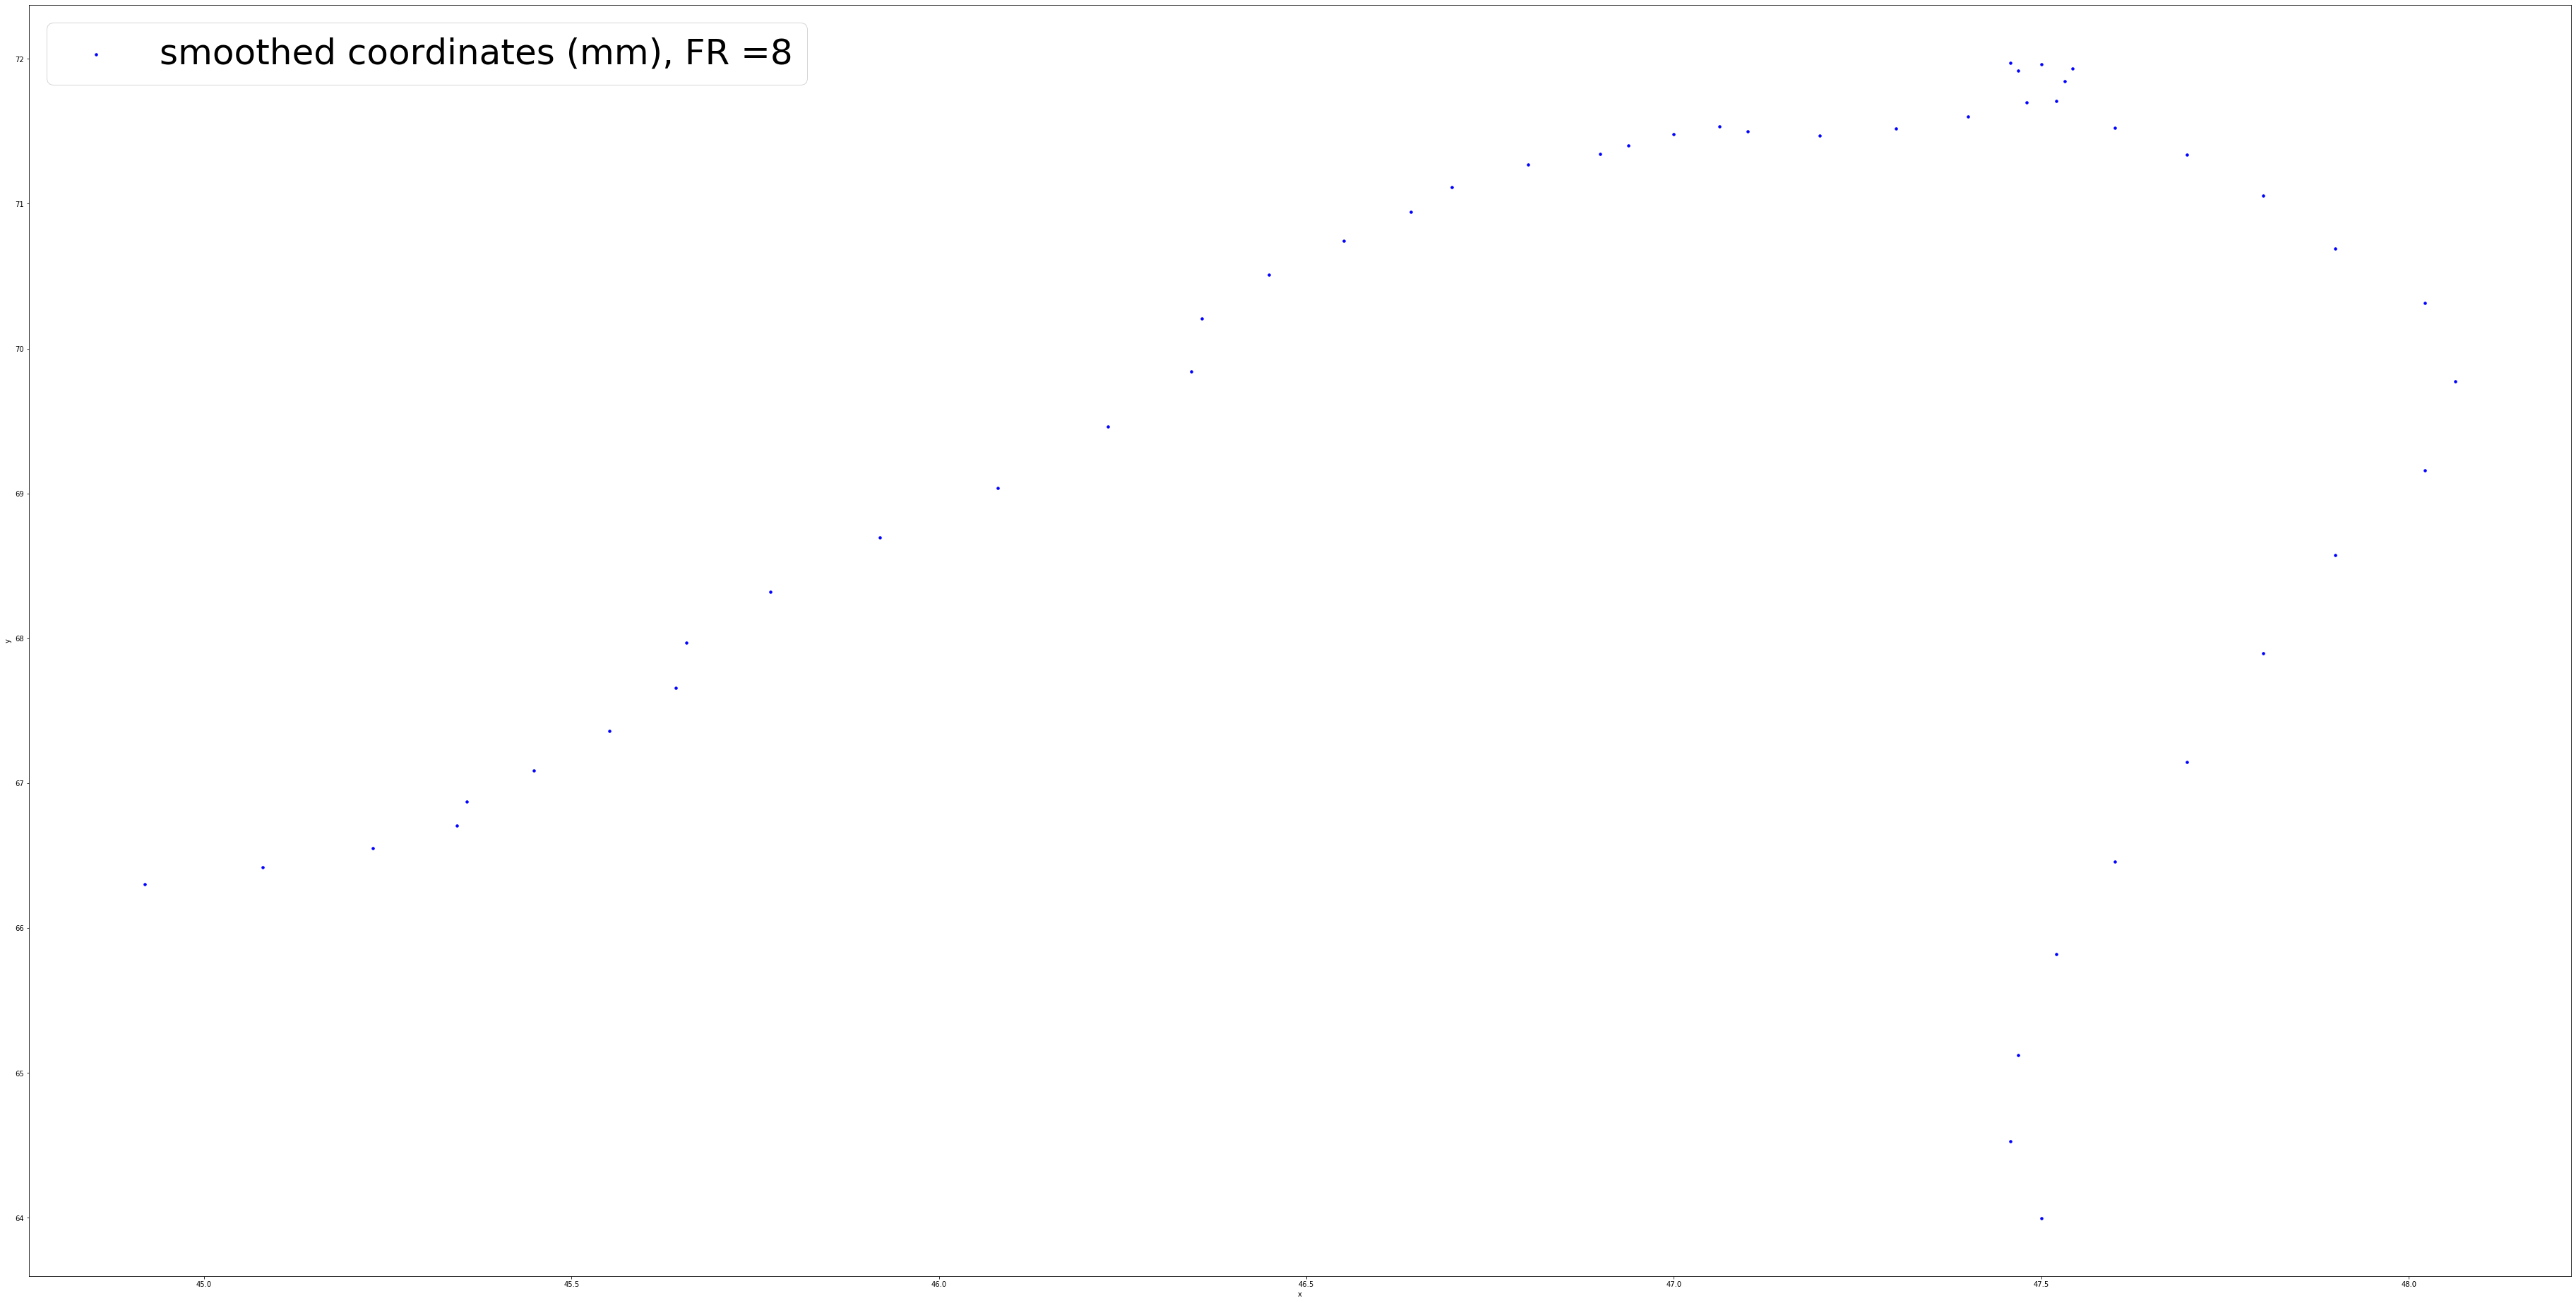

range(200, 370)
170
170


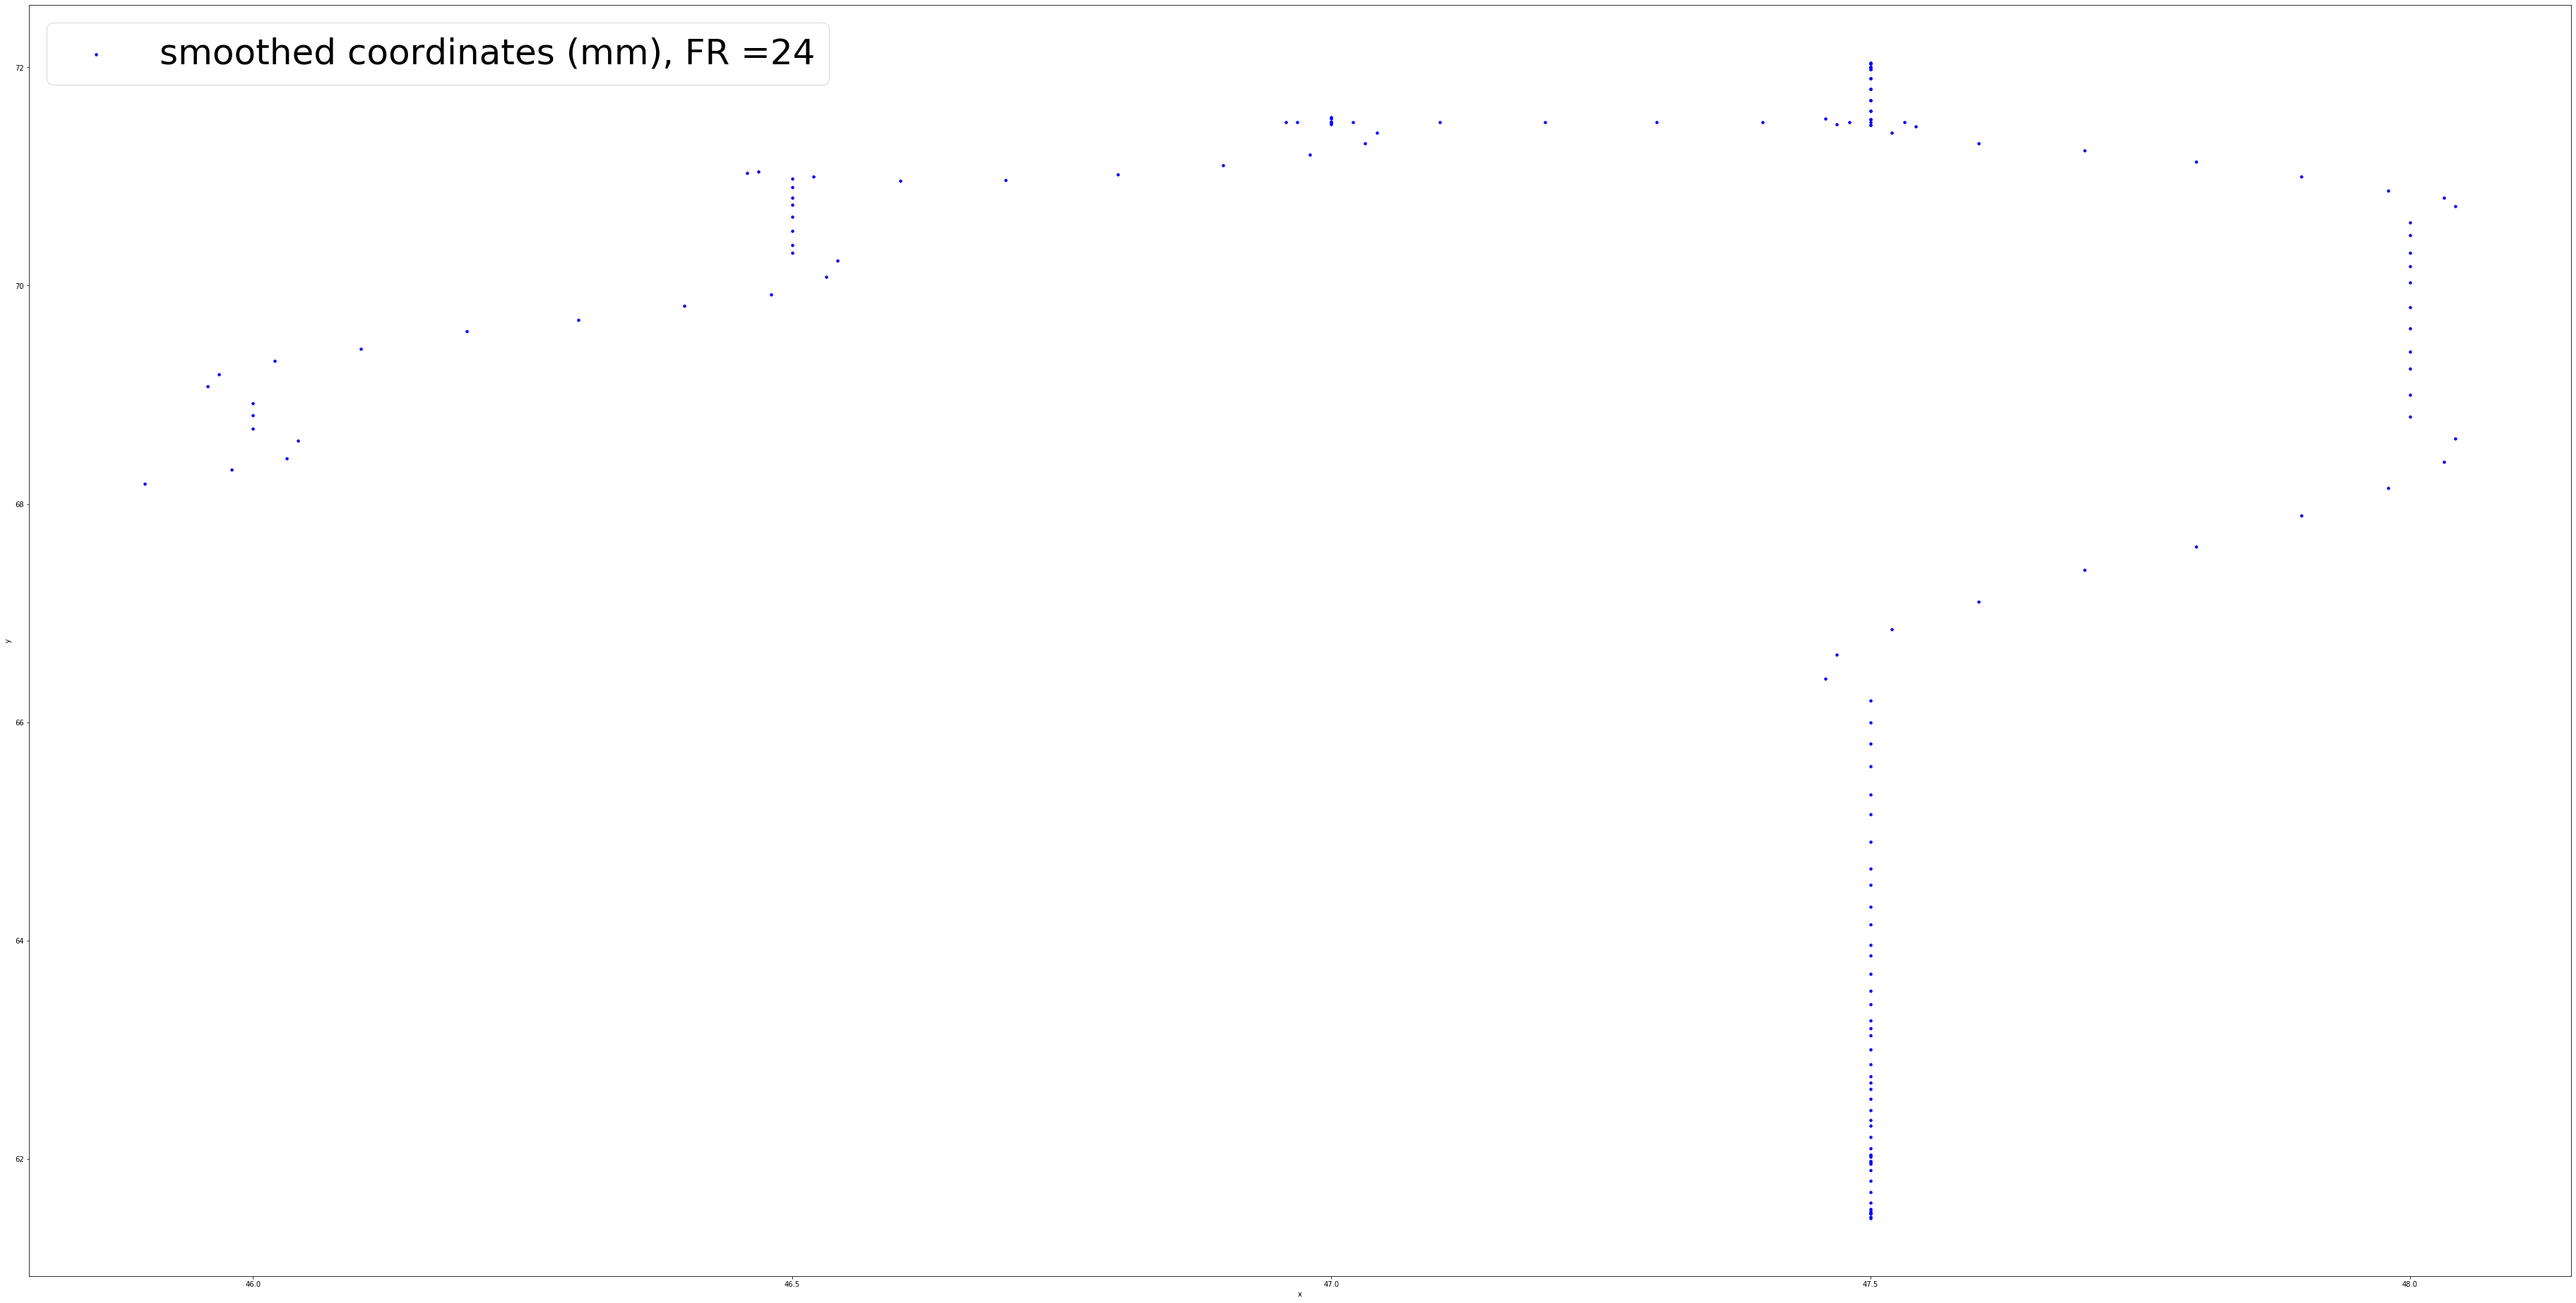

In [8]:
#for curve 34 there was different smoothing for each FR for the specified range
info_file_low34 = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/FR_test_lower/CRV_34.json"
info_file_high34 = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/FR_test_higher/CRV_34.json"
animals_low34 = animal.getAnimalObjs( info_file_low34 )
animals_high34 = animal.getAnimalObjs( info_file_high34 )

PlotCurve(animals_low34[3], zoom_in_for_fr_range = range(58,108))
PlotCurve(animals_high34[0], zoom_in_for_fr_range = range(200,370))

In [9]:
def computeOneBDD(animal_obj_0, animal_obj_1, varnames, seg_start_time_0, seg_end_time_0, seg_start_time_1, seg_end_time_1, norm_mode, fullmode=False, outdir=None):
  """ Computes the Behavioural Distortion Distance (BDD) between 
   two animal trajectories by applying Dynamic Time Warping (DTW),
   each starting and ending at the respective time frame given in 
   the function call.

  :Parameters:
    animal_obj_0/1 : animal object
     from animal.py, initialized
    varnames : list
     variable names (str)
    seg_start/end_time_0/1 : int or float
      time in minutes
    norm_mode : str, either 'baseline' or 'spec'
     baseline mode uses the mean and standard deviation from the
     baseline observation time to normalize each variable data,
     whereas the spec mode uses the mean and standard deivation 
     from the time period specified for this comparison.
    fullmode : bool
     if True, the method first obtains the full suite of returns
     from dtw_ext and writes several path graphs
    outdir : string
     path to the output directory

  :Returns:
    bdd : float
     behavioural distortion distance
  """

  #quick sanity check for output mode
  if fullmode and outdir == None:
    throwError("Full mode requires the path to output directory")

  seg_start_frame_0 = animal.getFrameNum(animal_obj_0, seg_start_time_0)
  seg_end_frame_0 = animal.getFrameNum(animal_obj_0, seg_end_time_0)
  data_0 = animal_obj_0.getMultRawVals(varnames, seg_start_frame_0, seg_end_frame_0)

  seg_start_frame_1 = animal.getFrameNum(animal_obj_1, seg_start_time_1)
  seg_end_frame_1 = animal.getFrameNum(animal_obj_1, seg_end_time_1)
  data_1 = animal_obj_1.getMultRawVals(varnames, seg_start_frame_1, seg_end_frame_1)

  print("LOG: Applying DTW to the data from files %s and %s..." % (animal_obj_0.getName(), animal_obj_1.getName()))
  
  numVars = len(varnames)

  if norm_mode == 'baseline':
    for i in range(numVars):
      m, s = animal_obj_0.getStats(varnames[i], 'baseline')
      data_0[i] = animal.normalize(data_0[i], m, s)
      m, s = animal_obj_1.getStats(varnames[i], 'baseline')
      data_1[i] = animal.normalize(data_1[i], m, s)
  elif norm_mode == 'spec':
    for i in range(numVars):
      m, s = animal.norm(data_0[i])
      data_0[i] = animal.normalize(data_0[i], m, s)
      m, s = animal.norm(data_1[i])
      data_1[i] = animal.normalize(data_1[i], m, s)
  dist, cost, alignment = extendedDTW.dtw_ext(data_0, data_1, dist_only=False)
  #dist is the integral part of the BDD formula
  scaler = len(alignment[0]) #arclength of the alignment
  bdd = dist/scaler
  print("LOG: distance between %s and %s: %.5f" % (animal_obj_0.getName(), animal_obj_1.getName(), bdd))

  if fullmode:
    #save alignment graphs in directory specified
    write.renderAlignment(alignment, animal_obj_0, animal_obj_1, varnames, outdir)
    for i in range(numVars): 
      v = varnames[i]
      if not os.path.exists(outdir): os.makedirs(outdir)
      write.renderAlignedGraphs(data_0[i], data_1[i], alignment, animal_obj_0, animal_obj_1, v, outdir)

      #For individual plots, enable the following two lines
      #write.renderSingleAnimalGraph(data_0[i], animal_obj_0, v, outdir)
      #write.renderSingleAnimalGraph(data_1[i], animal_obj_1, v, outdir)

  return bdd

In [10]:
def computeAllBDD(animal_list, varnames, seg_start_time, seg_end_time, norm_mode):
  """ Computes the BDD of each pair of trajectories in animal_list, all 
   starting and ending at the respective time frame given in the function call.

  :Parameters:
    animal_list : list
     from animal.py, initialized
    varnames : list
     variable names (str)
    seg_start/end_time : int or float
      time in minutes
    norm_mode : str, either 'baseline' or 'spec'
     baseline mode uses the mean and standard deviation from the
     baseline observation time to normalize each variable data,
     whereas the spec mode uses the mean and standard deivation 
     from the time period specified for this comparison.

  :Returns:
    BDD : 2D array of float (upper-triangular, empty diagonal)
     BDD[i][j] is the bdd between trajectories of animal[i] and
     animal[j]
    
  """
  num_animals = len(animal_list)
  BDD = [['' for i in range(num_animals)] for j in range(num_animals)]
  for i in range(num_animals):
    for j in range(i+1, num_animals):
      bdd = computeOneBDD(animal_list[i], animal_list[j], varnames, seg_start_time, seg_end_time, seg_start_time, seg_end_time, norm_mode) 
      BDD[i][j] = bdd
  return BDD


def computeOneIIBDD(animal_obj, varnames, norm_mode, interval_length=None, start_time=None, end_time=None):
  """ Computes Behavioural Distortion Distance (BDD) from an animal's
    trajectory to itself over a random pair of non-overlapping intervals. 

   :Parameters:
    animal_obj : animal object, initialized
    varnames : list
     variable names (str)
    norm_mode : str, either 'baseline' or 'spec'
     baseline mode uses the mean and standard deviation from the
     baseline observation time to normalize each variable data,
     whereas the spec mode uses the mean and standard deivation 
     from the time period specified for this comparison.
    interval_legth : length of the interval to use. If unspecified, it will
     be chosen at random.
    start_time : float, time in minutes
     time where the intervals can start. If omitted, exp start time is used
    end_time : float, time in minutes
     time where the intervals can end. If omitted, exp end time is used.

   :Returns:
     list with two entries containing the length of the time interval 
     for comparison, distance (BDD) returned
  """

  if start_time == None:
    start_time = animal_obj.getExpStartTime()
  if end_time == None:
    end_time = animal_obj.getExpEndTime()

  if interval_length == None:
  # No interval lengths are specified, so we are going to generate random interval lengths
    x = sorted([random.uniform(start_time,end_time) for i in range(3)])
    interval_length = (x[0]-start_time)/2
  else:
    x = sorted([2*interval_length+start_time]+[random.uniform(2*interval_length+start_time,end_time) for i in range(2)])

  interval_start_time_0 = x[1]-2*interval_length
  interval_end_time_0 = x[1]-interval_length
  interval_start_time_1 = x[2]-interval_length
  interval_end_time_1 = x[2]
  
  bdd = computeOneBDD(animal_obj, animal_obj, varnames, interval_start_time_0, interval_end_time_0, interval_start_time_1, interval_end_time_1, norm_mode)

  return [interval_length, bdd]


def computeAllIIBDD(animal_list, varnames, norm_mode, num_exps, interval_lengths=None, outdir=None, outfilename=None, start_time=None, end_time=None):
  """ Computes the intra-individual Behavioural Distortion Distance (IIBDD) for
   each trajectory in animal_list, all starting and ending at the respective 
   time frame given in the function call.

   :Parameters:
    animal_obj : animal object, initialized
    varnames : list
     variable names (str)
    norm_mode : str, either 'baseline' or 'spec'
     baseline mode uses the mean and standard deviation from the
     baseline observation time to normalize each variable data,
     whereas the spec mode uses the mean and standard deivation 
     from the time period specified for this comparison.
    num_exps : int
     number of times to repeat the experiments
    interval_legths :  List or None
     list - list of length of the time interval length to use. 
          num_exps comparisons will be made for each length in the list
     None - a interval length for each test will be chosen at random to 
          be between 0.01 and half the total time
    outdir : str for output directory path
     if specified, the results will be written to a file (outfilename)
    outfilename : str for output file name
    start_time : float, time in minutes
     time where the intervals can start. If omitted, exp start time will
     be used.
    end_time : float, time in minutes
     time where the intervals can end. If omitted, exp end time will be
     used.

   :Returns:
    exp_table : 2D list
       exp_table[i][j] is the j-th interval comparison for the i-th animal in animal_list
       each entry is a double [interval lenth, distance].  

    additional returns if interval_lengths is given in the function call
     mean_table : 2D list
       mean_table[i][j][0] is the j-th interval_length, and 
       mean_table[i][j][1] is the mean of the distances from tests using 
       the j-th interval_length and i-th animal.
     std_table : 2D list
       std_table[i][j][0] is the j-th interval_length
       std_table[i][j][1] is the std of the distances from tests using 
       the j-th interval_length and i-th animal    
  """

  exp_table = []
  if interval_lengths == None:
  #lengths not specified => run random seg tests
    for animal_obj in animal_list:
      exp_list = []
      for i in range(num_exps):
        res = computeOneIIBDD(animal_obj, varnames, norm_mode, None, start_time, end_time)  
        exp_list.append(res)
      exp_table.append(exp_list)
    if outdir:
      write.writeSegmentExpsToCSV(animal_list, exp_table, None, None, outdir, outfilename)
    return exp_table
  else:
  #lengths given => run num_exps comparisons per length
    mean_table = []
    std_table = []

    for animal_obj in animal_list:
      exp_list = []
      mean_list = []
      std_list = []

      if start_time == None:
        start_time = animal_obj.getExpStartTime()
      if end_time == None:
        end_time = animal_obj.getExpEndTime()

      slice_areas = [0.5*((end_time-start_time)-2*length)**2 for length in interval_lengths]
      total_area = sum(slice_areas)
      num_exps_per_slice = [int(num_exps*slice_area/total_area) for slice_area in slice_areas]
      cum_exps_per_slice = [0]+[sum(num_exps_per_slice[:i+1]) for i in range(len(interval_lengths))]

      for j in range(len(interval_lengths)):
        interval_length = interval_lengths[j]
        num_slice_exps = num_exps_per_slice[j]
        for i in range(num_slice_exps):
          res = computeOneIIBDD(animal_obj, varnames, norm_mode, interval_length, start_time, end_time)  
          exp_list.append(res)
        m = np.mean(map(lambda x:x[1], exp_list[cum_exps_per_slice[j]:cum_exps_per_slice[j+1]]))
        s = np.std(map(lambda x:x[1], exp_list[cum_exps_per_slice[j]:cum_exps_per_slice[j+1]]))
        mean_list.append([interval_length,m])
        std_list.append([interval_length,s])
      exp_table.append(exp_list)
      mean_table.append(mean_list)
      std_table.append(std_list)

    if outdir:
    #Time to write the results into a file
      write.writeSegmentExpsToCSV(animal_list, exp_table, mean_table, std_table, outdir, outfilename)

    return exp_table, mean_table, std_table